In [1]:
'''
Исходный код к уроку 1.
Построение двухслойной нейронный сети для классификации цветков ириса
'''

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sklearn здесь только, чтобы разделить выборку на тренировочную и тестовую
from sklearn.model_selection import train_test_split

In [2]:
np.random.seed(1)
### Шаг 1. Определение функций, которые понадобяться для обучения
# преобразование массива в бинарный вид результатов
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

# преобразование массива в необходимый вид
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))

    for i in range(len(Y)):
        l = Y[i]
        for j in range(len(l)):
            if(l[j] == 1):
                arr[i] = j+1
    return arr

# сигмоида и ее производная
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x)*(1 - sigmoid(x))

# нормализация массива
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

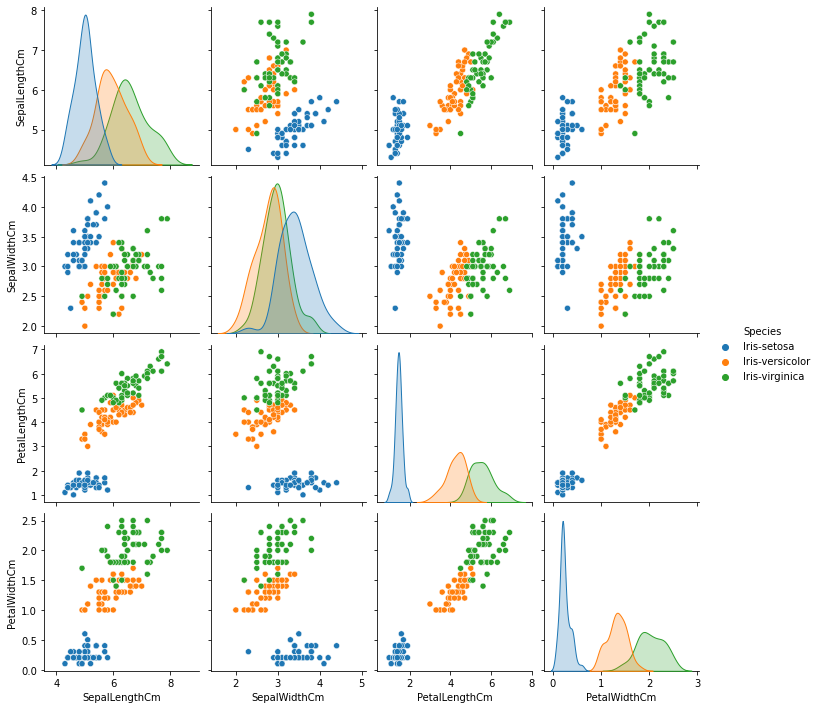

In [3]:

### Шаг 2. Подготовка тренировочных данных
# получения данных из csv файла. укажите здесь путь к файлу Iris.csv
iris_data = pd.read_csv("Iris.csv")
# print(iris_data.head()) # расскоментируйте, чтобы посмотреть структуру данных

# репрезентация данных в виде графиков
g = sns.pairplot(iris_data.drop("Id", axis=1), hue="Species")
# plt.show() # расскоментируйте, чтобы посмотреть

# замена текстовых значений на цифровые
iris_data['Species'].replace(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], [0, 1, 2], inplace=True)

# формирование входных данных
columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
x = pd.DataFrame(iris_data, columns=columns)
#x = normalize(x.as_matrix())
x = normalize(x.values)

# формирование выходных данных(результатов)
columns = ['Species']
y = pd.DataFrame(iris_data, columns=columns)
#y = y.as_matrix()
y = y.values
y = y.flatten()
y = to_one_hot(y)

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)

переписал в виде функции, можно задавать промежуточные слои нейронки, learning_rate количество эпох.

In [4]:
def fit_nn(X, y, n_epoche=100, layers_size=[4, 5, 3], learning_rate=0.1):
    '''
    Input:
        X: df with train data
        y: np.arrya with OHE target
        n_epoche: int, numpers of epoches to calculate
        layers_size: list with shape of all lvls
        learning_rate: float coefficient for gradient algoritm 
    Output:
        errors: list with errors on eache epoche
        accuracy: accuracy
        layers[-1]: last layer in neural network
        w: list of interactionы
    '''
    np.random.seed(1)
    errors = []
    n_layers = len(layers_size)
    w = [2*np.random.random((layers_size[i], layers_size[i+1])) - 1 for i in range(n_layers-1)]
  
    layers = [0 for i in range(n_layers)]
    layers[0] = X
    layers_error = [0 for i in range(n_layers)]
    layers_error[-1] = y
    layers_delta =[0 for i in range(n_layers - 1)]


    for epoche in range(n_epoche):
        # прямой проход
        for i in range(1, n_layers):
            layers[i] = sigmoid(np.dot(layers[i-1], w[i-1]))
        # обратный проход
        layers_error[-2] = layers_error[-1] - layers[-1]
        layers_delta[-1] = layers_error[-2] * sigmoid_deriv(layers[-1])

        for i in range(-2, -n_layers, -1):
            layers_error[i-1] = layers_delta[i+1].dot(w[i+1].T)
            layers_delta[i] = layers_error[i-1] * sigmoid_deriv(layers[i])

        for i in range(-1, -n_layers, -1):
            w[i] += layers[i-1].T.dot(layers_delta[i]) * learning_rate

        error = np.mean(np.abs(layers_error[-2]))
        errors.append(error)
        accuracy = (1 - error) * 100
    return errors, accuracy, layers[-1], w 

In [5]:
errors, accuracy, layer2, w = fit_nn(X_train, y_train,learning_rate=0.1, n_epoche=300,layers_size=[4, 5, 3])

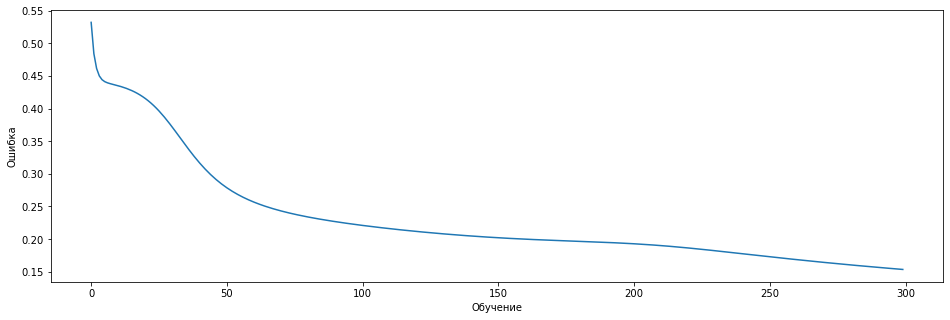

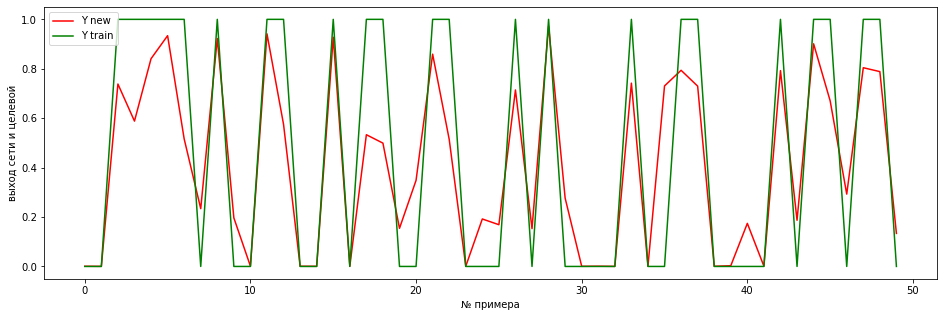

Аккуратность нейронной сети 84.66%


In [6]:
### Шаг 4. Демонстрация полученных результатов
# черчение диаграммы точности в зависимости от обучения
plt.figure(figsize = (16,5))
plt.plot(errors)
plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.show() # расскоментируйте, чтобы посмотреть 

N = 50
plt.figure(figsize = (16,5))
plt.plot(layer2[:N,1], 'r',label = 'Y new')
plt.plot(y_train[:N,1],'g', label = 'Y train')
plt.xlabel('№ примера')
plt.ylabel('выход сети и целевой')
plt.legend( )
plt.show() # расскоментируйте, чтобы посмотреть 
        
print("Аккуратность нейронной сети " + str(round(accuracy,2)) + "%")


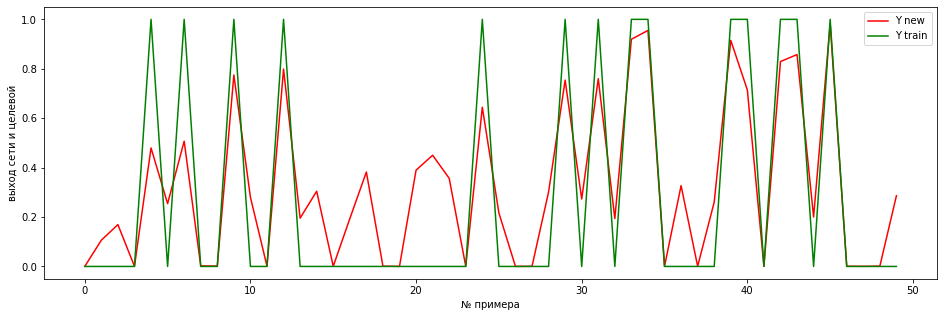

Аккуратность нейронной сети на тесте 84.65%


In [7]:
# прямое распространение(feed forward)
layer0_t = X_test
for w_i in w:
    layer0_t = sigmoid(np.dot(layer0_t, w_i))

layer_last_error_t = y_test - layer0_t
    
    
N = 50
plt.figure(figsize = (16,5))
plt.plot(layer0_t[:N,1], 'r',label = 'Y new')
plt.plot(y_test[:N,1],'g', label = 'Y train')
plt.xlabel('№ примера')
plt.ylabel('выход сети и целевой')
plt.legend( )
plt.show() # расскоментируйте, чтобы посмотреть

# метрика модели
error_t = np.mean(np.abs(layer_last_error_t))
accuracy_t = (1 - error_t) * 100
print("Аккуратность нейронной сети на тесте " + str(round(accuracy_t,2)) + "%")

In [8]:
from sklearn.metrics import f1_score

In [9]:
layer0_t = np.where(layer0_t > 0.5, 1, 0)

In [10]:
f1_score(y_test, layer0_t, average='micro')

0.9583333333333334

In [11]:
learning_rates = np.linspace(0.01, 1, 20).round(2)
n_epoches = np.array([25 * 2 ** i for i in range(10)])
results = pd.DataFrame(np.zeros((learning_rates.size, n_epoches.size)), columns=n_epoches, index=learning_rates)
results.head(2)


,25,50,100,200,400,800,1600,3200,6400,12800
0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
%%time
for rate in learning_rates:
    for epoche in n_epoches:
        errors, accuracy, layer2, w = fit_nn(
            X_train, y_train,
            learning_rate=rate,
            n_epoche=epoche,
            layers_size=[4, 5, 3]
        )
        layer0_t = X_test
        for w_i in w:
            layer0_t = sigmoid(np.dot(layer0_t, w_i))
        layer0_t = np.where(layer0_t > 0.5, 1, 0)
        results.at[rate, epoche] = round(f1_score(y_test, layer0_t, average='micro'), 2)

<ipython-input-2-0732abf9179e>:24: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
Wall time: 50.8 s


In [13]:
results

,25,50,100,200,400,800,1600,3200,6400,12800
0.01,0.00,0.00,0.00,0.00,0.73,0.73,0.77,0.98,0.96,0.98
0.06,0.00,0.53,0.73,0.77,0.77,0.97,0.96,0.98,0.98,0.98
0.11,0.25,0.73,0.77,0.77,0.97,0.96,0.98,0.98,0.98,0.98
0.17,0.75,0.74,0.77,0.79,0.96,0.96,0.98,0.98,0.98,0.98
0.22,0.73,0.76,0.85,0.85,0.90,0.96,0.98,0.98,0.98,0.98
0.27,0.73,0.75,0.82,0.90,0.62,0.62,0.62,0.62,0.62,0.62
0.32,0.73,0.77,0.82,0.62,0.62,0.62,0.62,0.62,0.62,0.62
0.37,0.63,0.72,0.94,0.62,0.62,0.62,0.62,0.62,0.62,0.62
0.43,0.51,0.51,0.62,0.62,0.62,0.62,0.62,0.62,0.62,0.62
0.48,0.63,0.62,0.68,0.62,0.62,0.62,0.62,0.62,0.62,0.63


In [17]:
from seaborn import heatmap

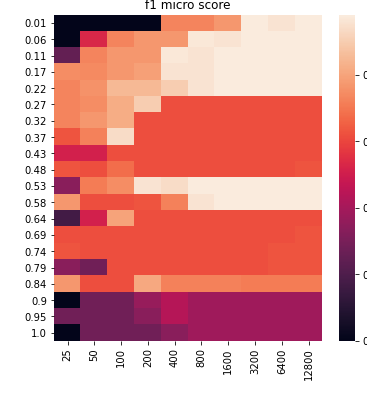

In [23]:
f, ax = plt.subplots(figsize=(6, 6))
plt.title('f1 micro score')
ax = heatmap(results)

Достаточно забавно посмотреть, что результат сходится на разном количестве эпох и ленинг рейте. Так же есть места где мы приходим к хорошему прогнозу, но с последующими эпохами алгоритм расходится.

Возьмем сетку с 2 мя скрытыми уровнями.

In [28]:
first_hiden_lvl = np.array([1,2,3,4,5,6,7,8,9,10])
second_hiden_lvl = np.array([1,2,3,4,5,6,7,8,9,10])

In [36]:
results2 = pd.DataFrame(np.zeros((first_hiden_lvl.size, second_hiden_lvl.size)), columns=first_hiden_lvl, index=second_hiden_lvl)
results2.head(2)

,1,2,3,4,5,6,7,8,9,10
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
%%time
for lvl_1 in first_hiden_lvl:
    for lvl_2 in second_hiden_lvl:

        errors, accuracy, layer2, w = fit_nn(
            X_train, y_train,
            learning_rate=0.06,
            n_epoche=5000,
            layers_size=[4, lvl_1, lvl_2, 3]
        )

        layer0_t = X_test
        for w_i in w:
            layer0_t = sigmoid(np.dot(layer0_t, w_i))

        layer0_t = np.where(layer0_t > 0.5, 1, 0)
        results2.at[lvl_1, lvl_2] = round(f1_score(y_test, layer0_t, average='micro'), 2)

<ipython-input-2-0732abf9179e>:24: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
Wall time: 1min 7s


In [41]:
results2

,1,2,3,4,5,6,7,8,9,10
1,0.33,0.62,0.62,0.62,0.62,0.62,0.62,0.63,0.63,0.62
2,0.33,0.62,0.62,0.62,0.62,0.62,0.62,0.63,0.98,0.62
3,0.33,0.57,0.98,0.62,0.95,0.98,0.98,0.62,0.96,0.83
4,0.33,0.63,0.98,0.94,0.98,0.84,0.98,0.98,0.94,0.98
5,0.33,0.74,0.98,0.62,0.62,0.98,0.98,0.95,0.98,0.96
6,0.33,0.63,0.72,0.96,0.96,0.76,0.98,0.98,0.63,0.96
7,0.33,0.60,0.89,1.00,0.98,0.97,0.98,0.98,0.94,0.98
8,0.33,0.65,0.96,0.96,0.98,0.98,0.83,0.98,0.96,0.98
9,0.33,0.67,0.98,0.90,0.98,0.95,0.98,0.97,1.00,0.98
10,0.33,0.76,0.98,0.95,0.79,0.98,0.98,0.98,0.96,0.98


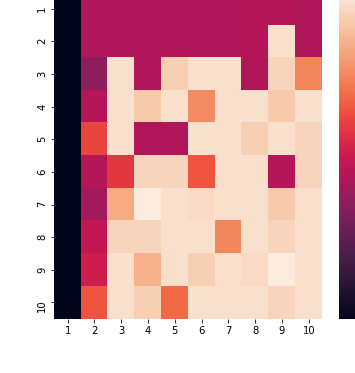

In [38]:
f, ax = plt.subplots(figsize=(6, 6))
plt.title('f1 micro score')
ax = heatmap(results2)

в общем видно что увеличение количество нейронов, увеличивает качество. 1 нейрон освсем не работате, 2 нейрона тоже не очень хорошо. На двухуровневой сети есть даже 2 результата с f1=1.